It is necessary to clone the repository for the whole exercise to work.

In [1]:
!git clone https://github.com/AlejandroNunezArroyo/VisionTest.git

Cloning into 'VisionTest'...
remote: Enumerating objects: 1115, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 1115 (delta 6), reused 15 (delta 4), pack-reused 1098
Receiving objects: 100% (1115/1115), 194.89 MiB | 26.38 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Checking out files: 100% (1153/1153), done.


In [2]:
import os
import zipfile

We used the following dataset obtained from Kaggle, the difference is that we eliminated images with more than one person in the image, we also eliminated images containing text which were obtained from commercials or promotions of the face masks. 
Directory of our training dataset of masked and unmasked persons. 
[Reference](https://github.com/DavidReveloLuna/MaskDetection)

For this exercise we used the TensorFLow library, this CNN algorithm will help us to detect the presence of a mask on a person's face.

In [3]:
# Directory with our training horse pictures
train_mask_dir = os.path.join('VisionTest/FaceDataset/images/MASK')

# Directory with our training human pictures
train_sinmask_dir = os.path.join('VisionTest/FaceDataset/images/SINMASK/')

Let's see what the filenames look like in the `train_mask_names` and `train_sinmask_names` training directories:

In [4]:
train_mask_names = os.listdir(train_mask_dir)
print(train_mask_names[:10])

train_sinmask_names = os.listdir(train_sinmask_dir)
print(train_sinmask_names[:10])

['979.png', 'asian_mask133.jpg', 'asian_mask173.jpg', 'asian_mask262.jpg', 'asian_mask240.jpg', 'asian_mask113.jpg', 'asian_mask186.jpg', 'crowd_mask198.jpg', 'asian_mask10.jpg', 'asian_mask277.jpg']
['156.jpg', 'new_226.jpg', 'new_168.jpg', '120.jpg', 'new_146.jpg', '62.jpg', 'new_244.jpg', 'new_108.jpg', '15.jpg', 'new_121.jpg']


Total number of images used for training of mask wearers and non-mask wearers. 

In [5]:
print('total training horse images:', len(os.listdir(train_mask_dir)))
print('total training human images:', len(os.listdir(train_sinmask_dir)))

total training horse images: 368
total training human images: 401


In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

A batch of 8 images of people with masks and 8 people without masks is displayed. 

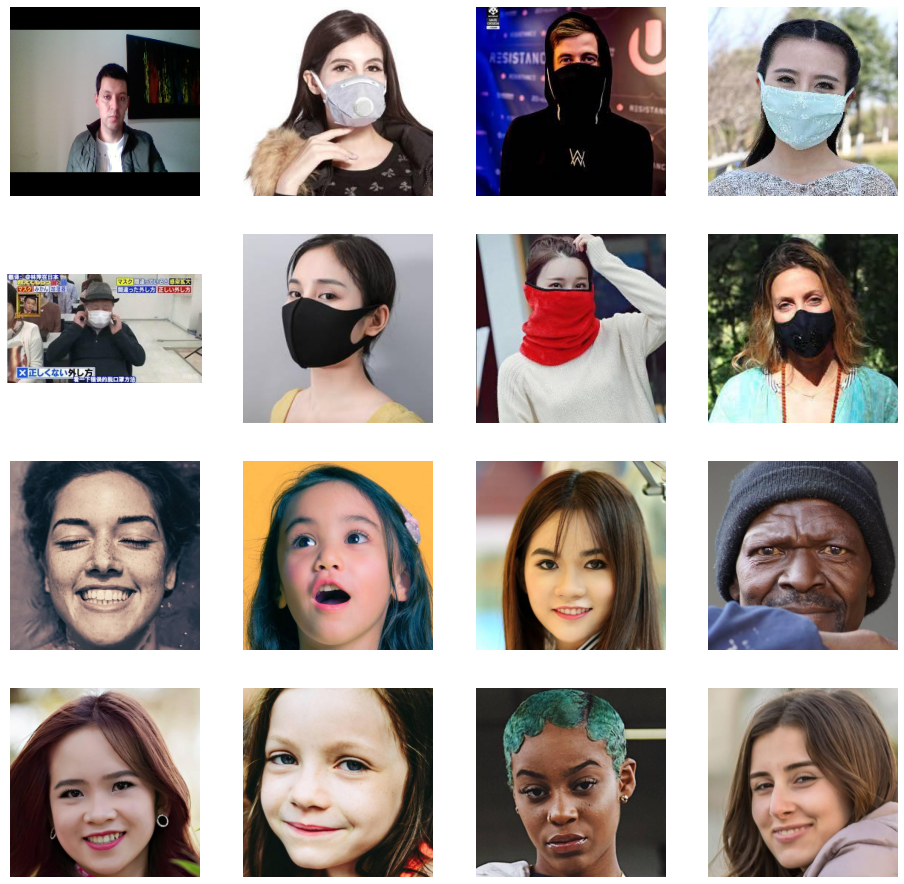

In [7]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_mask_dir, fname) 
                for fname in train_mask_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_sinmask_dir, fname) 
                for fname in train_sinmask_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Building a model

In [8]:
import tensorflow as tf

Convolution layers are added to the model.

In [9]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

The model.summary()

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [11]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

### Data Preprocessing

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'VisionTest/FaceDataset/images/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


Found 777 images belonging to 3 classes.


### Training


In [13]:
history = model.fit(
      train_generator,
      steps_per_epoch=6,  
      epochs=22,
      verbose=1)

Epoch 1/22
6/6 [==============================] - 38s 735ms/step - loss: 0.8276 - accuracy: 0.4783
Epoch 2/22
6/6 [==============================] - 4s 653ms/step - loss: 0.6993 - accuracy: 0.5227
Epoch 3/22
6/6 [==============================] - 4s 685ms/step - loss: 0.6470 - accuracy: 0.5839
Epoch 4/22
6/6 [==============================] - 4s 699ms/step - loss: 0.9891 - accuracy: 0.6490
Epoch 5/22
6/6 [==============================] - 4s 684ms/step - loss: 0.5040 - accuracy: 0.7670
Epoch 6/22
6/6 [==============================] - 4s 687ms/step - loss: 0.5564 - accuracy: 0.7247
Epoch 7/22
6/6 [==============================] - 4s 654ms/step - loss: 0.4163 - accuracy: 0.8311
Epoch 8/22
6/6 [==============================] - 4s 689ms/step - loss: 0.2886 - accuracy: 0.8817
Epoch 9/22
6/6 [==============================] - 4s 683ms/step - loss: 0.7111 - accuracy: 0.8236
Epoch 10/22
6/6 [==============================] - 4s 615ms/step - loss: 0.4202 - accuracy: 0.8193
Epoch 11/22
6/6 [=

###Running the Model

[1.]
 Sin mascara 


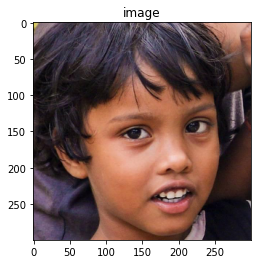

In [14]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

path = 'VisionTest/FaceDataset/images/TEST/0.jpg'
img = image.load_img(path, target_size=(300, 300))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes[0])
if classes[0]>0.5:
  print(" Sin mascara ")
else:
  print(" Con mascara ")

plt.title('image')
plt.imshow(img)
 

The following is the export of the model in h5, this simplification is used for the .py file

In [15]:
from keras.models import load_model

In [16]:
model.save('FaceDataset.h5')
model=load_model("FaceDataset.h5")